# Test out standardized ADCIRC, SELFE and FVCOM datasets
    
The datasets being accessed here are NetCDF files from ADCIRC, SELFE and FVCOM, with attributes added or modified virtually using NcML to meet the [UGRID conevntions standard for unstructured grid models](https://github.com/ugrid-conventions/ugrid-conventions/blob/v0.9.0/ugrid-conventions.md). 

This example was developed for the Integrated Ocean Observing System (IOOS) Coastal and Ocean Modeling Testbed. 

    https://ioos.noaa.gov/project/coastal-ocean-modeling-testbed-projects/


You can quickly and easily set up a conda environemnt that will run this by installing the conda_requirements_dev.txt file included in the `gridded` repo:

```
conda install --file conda_requirements_dev.txt
```

(ported from the examples in pyugrid)       

In [39]:
# get set up:
%matplotlib inline

from __future__ import print_function

# lets make sure gridded import first!
import gridded

# other useful packages

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#import netCDF4

print('Successfully loaded gridded version: {}'.format(gridded.__version__))


Successfully loaded gridded version: 0.0.1


## Define which models to work with

And set up some parameters.

In [40]:
# model urls:
models = dict(ADCIRC='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Rita_2D_final_run_without_waves',
              FVCOM='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/USF_FVCOM/Hurricane_Rita_2D_final_run_without_waves',
              SELFE='http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves')

bbox = [-95, -85, 27, 32]  # Set the bounding box.
variable = 'sea_surface_height_above_geoid'  # CF standard_name (or long_name, if no standard_name).
contour_levels = np.arange(-1, 5.0, 0.2)  # Set the contour levels.
start_time = datetime(2005, 9, 24, 5, 0, 0)  # UTC time

## Read the data


In [41]:
# load up a gridded.dataset of the ADCIRC model:
ds = gridded.Dataset(models['ADCIRC'])

### Get some information about this dataset

In [42]:
# Information about the grid:
print(ds.grid.info)

UGrid object:
Number of nodes: 417642
Number of faces: 826866 with 3 vertices per face


In [43]:
# what variables are there"
print("Variables available and their standard names:\n")
for name, var in ds.variables.items():
    print(name, ":", var.attributes['standard_name'])

Variables available and their standard names:

wind_max : maximum_wind
radstress_max : maximum_radiation_stress
zeta_max : maximum_sea_surface_height_above_geoid
u-vel : eastward_water_velocity
vel_max : maximum_water_velocity
pressure_min : minimum_air_pressure_at_sea_level
windy : northward_wind
pressure : air_pressure_at_sea_level
depth : depth below geoid
windx : eastward_wind
v-vel : northward_water_velocity
zeta : sea_surface_height_above_geoid


In [44]:
# we are interested in the sea surface height:
ssh = ds.variables['zeta']

# what times is it good for?
print("minimum time:", ssh.time.min_time)
print("manimum time:", ssh.time.max_time)

minimum time: 2005-09-18 00:10:00
manimum time: 2005-09-30 00:00:00


### Make the matplotlib triangulation object

NOTE: we should build some of this into the grid object.

In [45]:
# note that we are working with just the Variable object now...
lon = ssh.grid.node_lon
lat = ssh.grid.node_lat
faces = ssh.grid.faces

triang = tri.Triangulation(lon, lat, triangles=faces)

In [46]:
# extract the data at the time we want:
# in this case, at the native nodes
# NOTE: there should be a better way to get this than calling the interpolation function..
data = ssh.at(ssh.grid.nodes, start_time)
# NOTE: I'm getting some data masked -- something is odd. 
# Nope it's expected - J

In [47]:
# NOTE: good to put this in gridded.plotting...
# make a cartopy map:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 6),
                           subplot_kw=dict(projection=projection))
    ax.add_feature(cartopy.feature.LAND, zorder=1, alpha = 0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

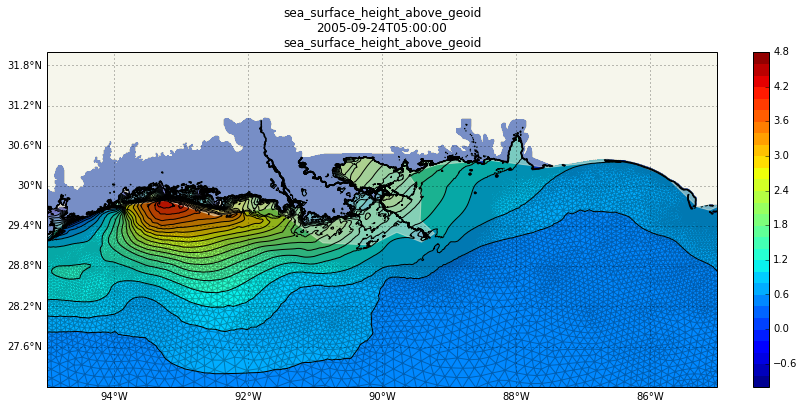

In [50]:
fig, ax = make_map()
ax.set_extent(bbox)
#Data grid lines
ax.triplot(triang, '-k',alpha=0.3)

#Contours
ax.tricontour(triang, data, colors='k', levels=contour_levels)
cs = ax.tricontourf(triang, data, levels=contour_levels)

cbar = fig.colorbar(cs, fraction=0.046, pad=0.04)

time_string = start_time.isoformat()
title = ax.set_title('{}\n{}\n{}'.format(variable,
                                         time_string,
                                         ssh.attributes['standard_name']))